In [ ]:
%pip install pandas
%pip install numpy
%pip install lxml
%pip install regex
%pip install matplotlib
%pip install scipy

In [2]:
import pandas as pd
import numpy as np
import regex as re
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
rankings = pd.read_html('./data/fifa-rankings-conmebol.html')[0]
rankings

,RK,Team,Total Points,Previous Points,+/-
0,1,ArgentinaARG,1855.20,1855.20,-
1,5,BrazilBRA,1784.09,1784.09,-
2,11,UruguayURU,1665.99,1665.99,-
3,141,ColombiaCOL,1655.29,1651.20,+4.09
4,32,EcuadorECU,1519.20,1519.20,-
5,35,PeruPER,1512.68,1512.68,-
6,40,ChileCHI,1489.82,1489.82,-
7,50-1,VenezuelaVEN,1447.20,1448.77,-1.57
8,53,ParaguayPAR,1430.73,1430.73,-
9,85,BoliviaBOL,1284.55,1284.55,-


In [4]:
# Clean the HTML
rankings['Abbreviation'] = rankings['Team'].str.extract(r'([A-Z][A-Z][A-Z])', expand=True)
rankings['Team'] = rankings['Team'].str.replace(r'([A-Z][A-Z][A-Z])', '', regex=True)

def fix_rank(row):
    if re.search(r"-\d\.\d+", row['+/-']):
        row['RK'] = re.sub(r"(-\d+)", "", row['RK'])
    elif re.search(r"\+\d\.\d+", row['+/-']):
        row['RK'] = row['RK'][:-1]
    return row

rankings = rankings.apply(lambda row: fix_rank(row), axis=1)
rankings = rankings[['RK', 'Team', 'Abbreviation']]
rankings['RK'] = pd.to_numeric(rankings['RK'])
rankings

,RK,Team,Abbreviation
0,1,Argentina,ARG
1,5,Brazil,BRA
2,11,Uruguay,URU
3,14,Colombia,COL
4,32,Ecuador,ECU
5,35,Peru,PER
6,40,Chile,CHI
7,50,Venezuela,VEN
8,53,Paraguay,PAR
9,85,Bolivia,BOL


In [5]:
results = pd.read_csv('./data/results.csv', encoding='latin-1').dropna()
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,id
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,1
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,2
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,3
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,4
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,5


In [6]:
# Modify results dataframe

def create_result(row):
    if row['home_score'] > row['away_score']:
        return 'W'
    elif row['home_score'] < row['away_score']:
        return 'L'
    else:
        return 'D'

# Create a result column which indictes whether the home team won, lost or drew.
results['result'] = results.apply(lambda row: create_result(row), axis=1)
# Convert to datetime
results['date'] = pd.to_datetime(results['date'])
# Only get results from the last 30 years
results = results[results['date'] >= datetime(1993, 1,1)]

results

,date,home_team,away_team,home_score,away_score,tournament,city,country,id,result
17120,1993-01-01,Ghana,Mali,1.0,1.0,Friendly,Libreville,Gabon,17121,D
17121,1993-01-02,Gabon,Burkina Faso,1.0,1.0,Friendly,Libreville,Gabon,17122,D
17122,1993-01-02,Kuwait,Lebanon,2.0,0.0,Friendly,Kuwait City,Kuwait,17123,W
17123,1993-01-03,Burkina Faso,Mali,1.0,0.0,Friendly,Libreville,Gabon,17124,W
17124,1993-01-03,Gabon,Ghana,2.0,3.0,Friendly,Libreville,Gabon,17125,L
...,...,...,...,...,...,...,...,...,...,...
43272,2023-11-22,Ecuador,Chile,1.0,0.0,FIFA World Cup qualification,Quito,Ecuador,43273,W
43273,2023-11-22,Uruguay,Bolivia,3.0,0.0,FIFA World Cup qualification,Montevideo,Uruguay,43274,W
43274,2023-11-22,Brazil,Argentina,0.0,1.0,FIFA World Cup qualification,Rio de Janeiro,Brazil,43275,L
43275,2023-11-22,Peru,Venezuela,1.0,1.0,FIFA World Cup qualification,Lima,Peru,43276,D


In [7]:
home_winrates = rankings[['RK', 'Team']]
home_winrates["Winrate"] = np.nan

def get_winrate(row):
    results_team = results[results['country'] == row['Team']]
    results_team = results_team[results_team['home_team'] == row['Team']]

    team_winrate = results_team.groupby('home_team')['result'].value_counts().unstack(level=-1)
    team_winrate['total'] = team_winrate.sum(axis=1)

    return (team_winrate['W'] / team_winrate['total']).iloc[0]

home_winrates['Winrate'] = home_winrates.apply(lambda row: get_winrate(row), axis=1)
home_winrates.set_index('Team', inplace=True)
home_winrates

,RK,Winrate
Team,,
Argentina,1,0.689655
Brazil,5,0.769841
Uruguay,11,0.650485
Colombia,14,0.604167
Ecuador,32,0.672566
Peru,35,0.455285
Chile,40,0.622222
Venezuela,50,0.393939
Paraguay,53,0.574257


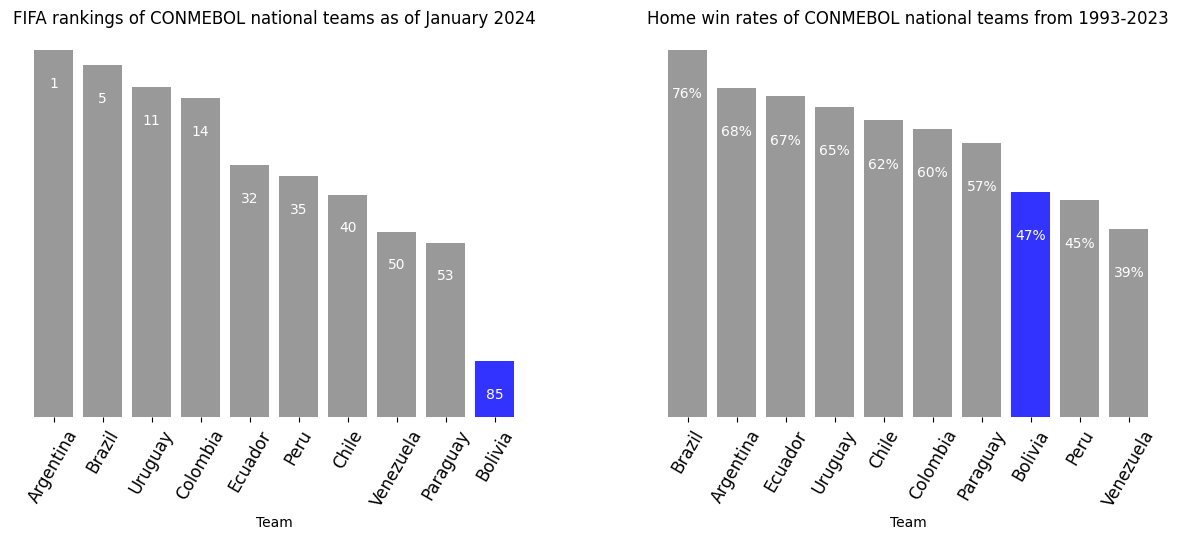

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15, 5))


''' First Subplot '''
ax1.set_title('FIFA rankings of CONMEBOL national teams as of January 2024')
# We need the bars to be inverted, with the highest ranked teams having the largest bars
bars1 = ax1.bar(home_winrates.index, 100-home_winrates['RK'], bottom=home_winrates['RK'], 
               color=['gray','gray','gray','gray','gray','gray','gray','gray','gray','blue'], alpha=0.8, linewidth=0)

ax1.invert_yaxis()
ax1.tick_params(axis="x", rotation=60, labelsize=12)
ax1.set_xlabel('Team')

for bar in bars1:
    bar.sticky_edges.y[:] = [100]
ax1.autoscale()

# Remove the y label
ax1.set_yticks([])

# Remove the frame of the chart
for spine in ax1.spines.values():
    spine.set_visible(False)

# Add the ranking to the bars themselves
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, 110 - bar.get_height(), str(int(100 - height)),
                   ha='center', color='w', fontsize=10)


''' Second Subplot '''

bars2 = ax2.bar(home_winrates.sort_values(by=['Winrate'], ascending=False).index, 
        home_winrates.sort_values(by=['Winrate'], ascending=False)['Winrate'], 
        color=['gray','gray','gray','gray','gray','gray','gray','blue','gray','gray'], alpha=0.8, linewidth=0)

ax2.set_title('Home win rates of CONMEBOL national teams from 1993-2023')
ax2.tick_params(axis="x", rotation=60, labelsize=12)
ax2.set_xlabel('Team')

# Remove the y label
ax2.set_yticks([])

# Remove the frame of the chart
for spine in ax2.spines.values():
    spine.set_visible(False)

# Add the percentages in the bars themselves
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.1, str(int(height*100)) + '%',
                   ha='center', color='w', fontsize=10)

In [9]:
results_bol = results[results['country'] == 'Bolivia']
results_bol = results_bol[results_bol['home_team'] == 'Bolivia']

def create_result(row):
    if row['home_score'] > row['away_score']:
        return 'W'
    elif row['home_score'] < row['away_score']:
        return 'L'
    else:
        return 'D'

# Create a result column which indictes whether the home team won, lost or drew.
results_bol['result'] = results_bol.apply(lambda row: create_result(row), axis=1)
# Convert to datetime
results_bol['date'] = pd.to_datetime(results_bol['date'])

bol_results_per_year = results_bol.groupby(results_bol.date.dt.year)['result'].value_counts()
bol_results_per_year = bol_results_per_year.unstack(level=-1).fillna(0)
bol_results_per_year['total'] = bol_results_per_year.sum(axis=1)


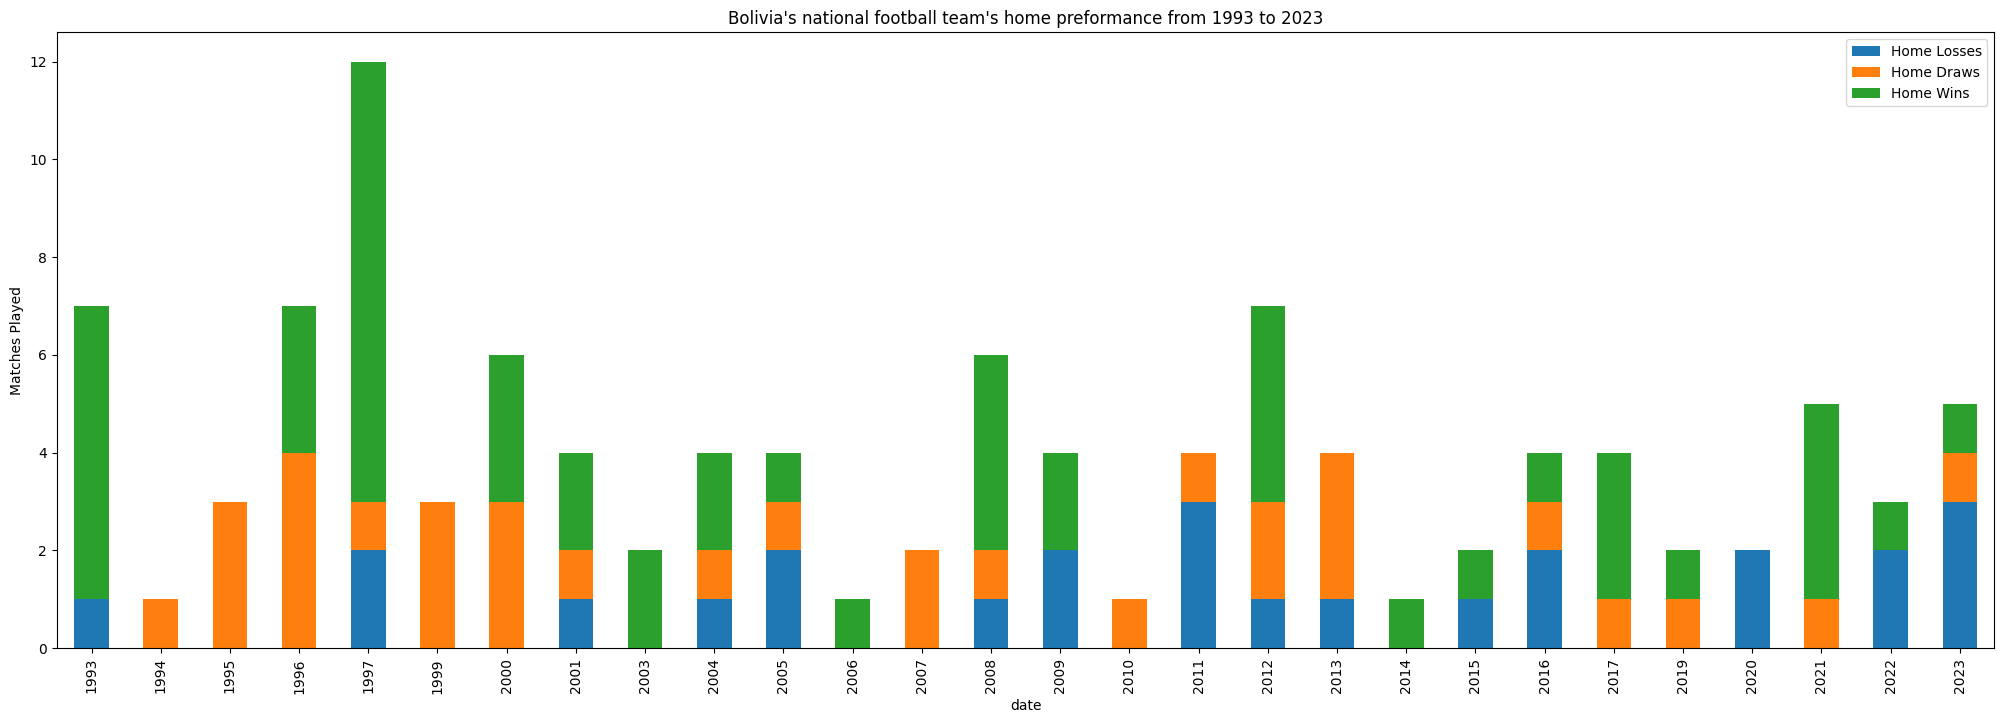

In [10]:
ax_bol = bol_results_per_year[['L','D','W']].plot(kind='bar', stacked=True, figsize=(25, 8), title='Bolivia\'s national football team\'s home preformance from 1993 to 2023');
ax_bol.set_ylabel('Matches Played');
ax_bol.legend(labels=['Home Losses', 'Home Draws', 'Home Wins'])